# Estimate-Petrophysical-Rock-Types-PRT-from-normalized-core-data-using-KNN

### Introduction

#### Predict Petrophysical Rock Types (PRT)

The objective of this project is to estimate Petrophysical Rock Types (PRTs) as defined by Clerke(1) for the Arab-D carbonate reservoir using just Porosity and Permeability. This project utilizes normalized Porosity and Permeability values. We calculate the Euclidean distance between the reference data and the normalized user defined poro-perm and determines the most likely PRT for the user defined values. 

The Arab D data set from Clerke is quite distinctive. Clerke acquired nearly 450 High Pressure Mercury Injection Capillary Pressure (HPMI) measurements in the Arab D reservoir; however, Clerke's final samples were randomly selected from 1,000's of pre-qualified core samples ensuring a broad distribution and representation of all Petrophysical properties.  Clerke fit a Thomeer hyperbolas to each pore system in each sample to generate the published Thomeer Capillary Pressure parameters including Bulk Volume Occupied (BVi), curvature of Capillary Pressure curve related to the variability of pore throats (Gi) and the Initial Displacement Pressures (Pdi) for each pore system i. From these data Clerke established the PRTs based on the Initial Displacement Pressures for each pore system and the number of pore systems present in each sample. From the figure below it is rather evident that Clerke's PRTs are Petrophysically well-defined where each color represents a different PRT.  The Capillary Pressure curves and Pore Throat Distributions (PTD) shown on the right hand side of the figure illustrate the unique characteristics of each PRT. 


![TS_Image](PRT.png)


###### The characterization of each PRTs is shown below:


![TS_Image](Rock-Types.png)


As can be seen in the first figure above, the PRTs are rather well segregated on the Porosity vs. Permeability Cross Plot as they fall in distinct regions or clusters on the Cross Plot. 

For modeling purposes it is important to take advantage of the excellent correlations between the Thomeer Capillary Pressure parameters. the correlation of core Permeability vs. the Mode of the Pore Throats Distribution has a high correlation coefficient of 0.88. Pd1 correlates to the Mode of the PTD with a correlation coefficient of 0.99. The Mode of the PTD can be calculated directly from the Thomeer Parameters using the following equation:

	Mode of PTD (microns) = exp(-1.15*G1) * (214/Pd1)

The calculated Mode of PTD above is located at the exact peak of the Capillary Pressure derivative-derived Pore Throat Distribution for the most dominate pore size, and this represents the most abundant pore throat for the sample. We have found that the Mode of the PTD to be very useful in the 2D and 3D modeling of Petrophysical Properties for both Carbonate and Clastic reservoirs. Winland's r35 tries to approximate the mode; however, Amaefule's FZI is the mean pore throat radius and falls between the two modes of a bi-modal carbonate sample. 


# IMPORTANT:  Input User Porosity and Permeability Data for Thomeer Parameter Estimates

The code for this program requires the user to input Porosity and Permeability, and then the program calculates the most probable Rock Type (Rock_Index) and provides a Capillary Pressure curve for that Rock Type considering the user provided porosity and permeability.


![TS_Image](knn_results.png)





1 Clerke, E. A., Mueller III, H. W., Phillips, E. C., Eyvazzadeh, R. Y., Jones, D. H., Ramamoorthy, R., Srivastava, A., (2008) “Application of Thomeer Hyperbolas to decode the pore systems, facies and reservoir properties of the Upper Jurassic Arab D Limestone, Ghawar field, Saudi Arabia: A Rosetta Stone approach”, GeoArabia, Vol. 13, No. 4, p. 113-160, October, 2008. 




The porosity vs. permeability cross plot is used as a road map to our petrophysical data that lies underneath with each poro-perm combination. The Rosetta Stone Thomeer poro-perm calibration data is shown in the upper left portion of the figure below. As you can see in this figure, by selecting a narrow range of poro-perm samples from the plot, the resulting capillary pressure curves in the lower left are very similar. This means that they also have similar PRTs and Thomeer parameters with similar Pd, G and BVocc.  We use proximity of our Geolog level-by-level poro-perm combination data to estimate the results from the nearest porosity and permeability from our calibration dataset and average the queried results by the number of nearest neighbors (kNN). 

  
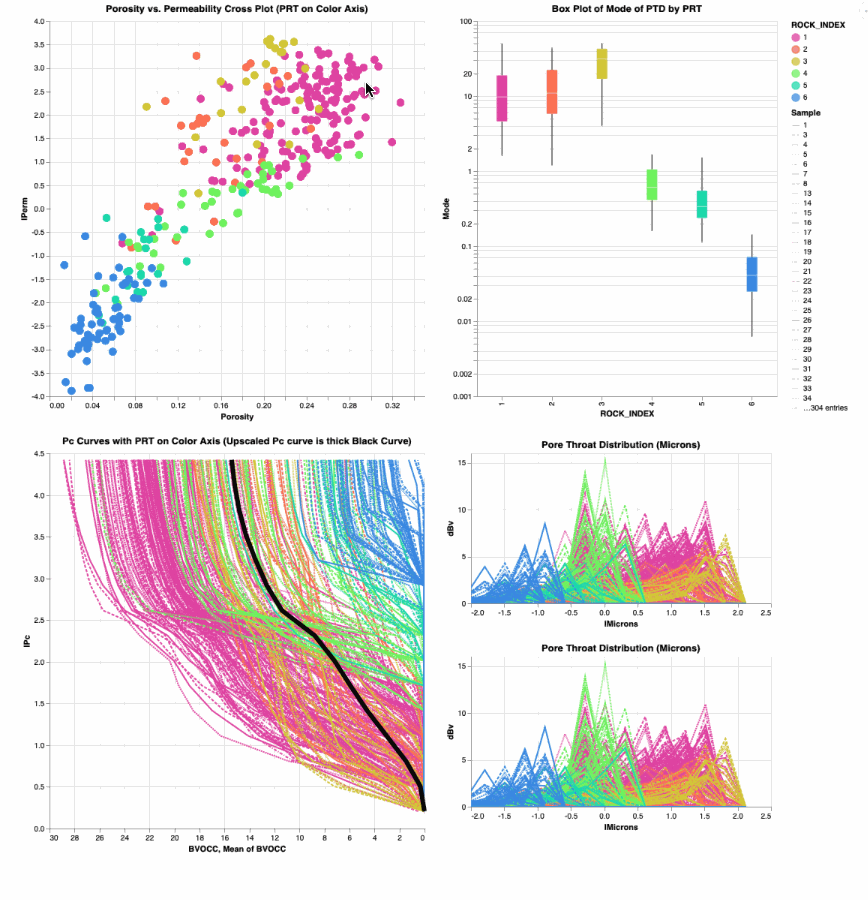
#####  Rosetta Stone Data Shown Above using Altair to Dynamically Link the Data



# IMPORTANT:  Input User Porosity and Permeability Data for Thomeer Parameter Estimates

In [1]:
phit = float(input('Input Porosity (fraction) = '))
perm = float(input('Input Permeability (mD) = '))

Input Porosity (fraction) = .2
Input Permeability (mD) = 222


## Basic kNN Code:

In [2]:
#!/usr/bin/env python3
# python loglan


# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


# =============================================================================
# # ===========================================================================
# # #-------------------------------------------------------------------------- 
# # #
# # #        Read in Reference data from the Excel file
# # #        Read in the reference Rosettta Stone Core dat
# # #        
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
#read the Excel .xlsx file - slow
file = r'./data/mapinv_reference_data_carbonates_calculatedMode_Rosetta.xlsx'
thomeer_core_data = pd.read_excel(file,index_col=False)
thomeer_core_data = thomeer_core_data.replace(-999.25,np.nan)


Permeability = thomeer_core_data['PERMEABILITY']
Porosity = thomeer_core_data['POROSITY']
G1 = thomeer_core_data['G1']
PD1 = thomeer_core_data['PD1']
G2 = thomeer_core_data['G2']
PD2 = thomeer_core_data['PD2']
BV1 = thomeer_core_data['BV1']
BV2 = thomeer_core_data['BV2']
Mode = thomeer_core_data['Mode']
ROCK_INDEX = thomeer_core_data['ROCK_INDEX']    

    
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #            Normally Read in  data from Geolog
# # #                   
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
#phit = .22
#perm = 360
por_min = 0
por_max = 0.4
perm_min = -4
perm_max = 4
n_neighbors = 5

 
Por = phit
Perm = perm


# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #
# # #            This is the beginning of kNN for Thomeer parameter Estimations
# # #
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
 
#normalized Geolog well Porosity and Permeability data
por = (Por-por_min)/(por_max - por_min)
perm= (math.log10(Perm) - perm_min)/(perm_max - perm_min) 
 
# =============================================================================
# #---------------------------------------------------------------------------- 
# #           
# #              ESTIMATE THOMEER PARAMETERS FOR BOTH PORE SYSTEMS
# #                   
# #----------------------------------------------------------------------------
# =============================================================================

dist_inv = []
dist_phi = []
dist_lperm = []
G1_weight = []
PD1_weight = []
BV1_weight = []
G2_weight = []
PD2_weight = []
BV2_weight = []
#Rock_Index_weight = []


dist_inv_total=0
G1_total  = 0
PD1_total = 0
BV1_total = 0
G2_total  = 0
PD2_total = 0
BV2_total = 0




inv_dist_array = []
#distance_knn_array = [rows,columns]
distance_knn_array = []


#------------------------------------------------------------------ 
#               Estimate all Thomeer Parameters for *_est values
#-------------------------------------------------------------------

Porosity_norm     = []
Permeability_norm = []


#this is the mapinv_reference_data being used 
for i in range(0,len(thomeer_core_data),1):

    Porosity_norm.append((Porosity[i] - por_min) / (por_max - por_min))
    Permeability_norm.append((math.log10(Permeability[i]) - perm_min) / (perm_max - perm_min))
     
    #Euclidian Distance
    dist_phi.append(   abs(por  - Porosity_norm[i]    ))  
    dist_lperm.append( abs(perm - Permeability_norm[i]))
    dist_inv.append( 1  /  math.sqrt(  dist_phi[i]**2 + dist_lperm[i]**2)  )

     
    #calculalte weights for each
    G1_weight.append(dist_inv[i]  * G1[i])
    PD1_weight.append(dist_inv[i] * PD1[i])
    BV1_weight.append(dist_inv[i] * BV1[i])
    G2_weight.append(dist_inv[i]  * G2[i])
    PD2_weight.append(dist_inv[i] * PD2[i])
    BV2_weight.append(dist_inv[i] * BV2[i])
    #Rock_Index_weight.append(dist_inv[i] * Rock_Index[i])
     


    inv_dist_array.append(dist_inv[i]);  # add items

# =============================================================================
###                    Create the KNN Array
# # ===========================================================================
# # #--------------------------------------------------------------------------
    distance_knn_array = [dist_inv, G1_weight, PD1_weight, BV1_weight, G2_weight, PD2_weight, BV2_weight, ROCK_INDEX]
#        distance_knn_array = [Permeability, Porosity, G1, PD1, BV1, G2, PD2, BV2]
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
#xnorm=np.array(Porosity_norm)
#ynorm=np.array(Permeability_norm)


# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #               Transpose and Sort the kNN array
# # #                   
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

#knn_array = np.transpose array
knn_array = np.transpose(distance_knn_array)
#print(knn_array)

#Sort array from large to low by column 0 which is dist_inv 
#xknn=np.array(knn_array)

#matsor x[x[:,column].argsort()[::-1]] and -1 us reverse order
mat_sort = knn_array[knn_array[:,0].argsort()[::-1]] #firt column reverse sort (-1)
#mat_sort = x[x[:,1].argsort()[::-1]]
#mat_sort = x[x[:,2].argsort()[::-1]]



# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #               Calculate knn Thomeer Parameters
# # #                   
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================


#------------------------------------------------------------------------------
#    Number of nearest Neighbors
#------------------------------------------------------------------------------
#n_neighbors = 3
#------------------------------------------------------------------------------

dist_inv_total_knn = 0
G1_total_knn = 0
PD1_total_knn = 0
BV1_total_knn = 0
G2_total_knn = 0
PD2_total_knn = 0
BV2_total_knn = 0
#Rock_Index_total_knn = 0



#kNN Estimates for first 3 rows
#dist_inv_total = mat_sort[0][0] + mat_sort[1][0] + mat_sort[2][0]
for i in range(0,n_neighbors,1):
    dist_inv_total_knn = dist_inv_total_knn + mat_sort[i][0]
    G1_total_knn  = G1_total_knn + mat_sort[i][1]
    PD1_total_knn = PD1_total_knn + mat_sort[i][2]
    BV1_total_knn = BV1_total_knn + mat_sort[i][3]
    G2_total_knn  = G2_total_knn + mat_sort[i][4]
    PD2_total_knn = PD2_total_knn + mat_sort[i][5]
    BV2_total_knn = BV2_total_knn + mat_sort[i][6]
    #Rock_Index_total_knn = Rock_Index_total_knn + mat_sort[i][7]
    #print(mat_sort[i][7])
     
     
# Estimate Thomeer parameters to be written into Geolog well
g1_est_knn  = G1_total_knn  / dist_inv_total_knn
pd1_est_knn = PD1_total_knn / dist_inv_total_knn
bv1_est_knn = (BV1_total_knn / dist_inv_total_knn)
g2_est_knn  = G2_total_knn  / dist_inv_total_knn
pd2_est_knn = PD2_total_knn / dist_inv_total_knn
bv2_est_knn = (BV2_total_knn / dist_inv_total_knn)
#mode = math.exp(-1.15*g1_est_knn) * (214/pd1_est_knn)
#Rock_Index_est_knn = int(Rock_Index_total_knn / n_neighbors)

# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #              Rock Type from Most Common in KNN series
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================  
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0]

#List = [mat_sort[0][7],mat_sort[1][7],mat_sort[2][7],mat_sort[3][7],mat_sort[4][7]]
List = []
rock_index_knn = []
rock_type = []
rocktype_remarks = []
color_prt = []

for d in range(0,n_neighbors):
    List.append(mat_sort[d,7])

most_frequent(List)   == rock_index_knn

bv3_est_knn = 0.0
g3_est_knn = 0.1
pd3_est_knn = 4500

#print(most_frequent(List)) 
if most_frequent(List)   == 1:
    rock_index_knn = 1
    rock_type = 'M_1'
    rocktype_remarks = 'Macro-Porous Rock with Meso-Porous Grains'  
    color_prt = 'CYAN'     
    mode = math.exp(-1.15*g1_est_knn) * (214/pd1_est_knn)
     
elif most_frequent(List) == 2: 
    rock_index_knn = 2    
    rock_type = 'M_2' 
    rocktype_remarks = 'Macro-Porous Rock with Micro-Porous Grains'    
    color_prt = 'DODGER_BLUE'
    mode = math.exp(-1.15*g1_est_knn) * (214/pd1_est_knn)
     
elif most_frequent(List) == 3:
    rock_index_knn = 3
    rock_type = 'M_1_2'
    rocktype_remarks = 'Macro-Porous Rock with Meso and Micro Grains'
    color_prt = 'BLUE'
    mode = math.exp(-1.15*g1_est_knn) * (214/pd1_est_knn)
     
elif most_frequent(List) == 4:
    rock_index_knn = 4
    rock_type = '1 '
    rocktype_remarks = 'Type 1 Meso-Porous Rock, uni-modal'
    color_prt = 'YELLOW'   
    mode = math.exp(-1.15*g2_est_knn) * (214/pd2_est_knn)
    bv2_est_knn =  bv1_est_knn + bv2_est_knn   
    bv1_est_knn = 0

elif most_frequent(List) == 5:
    rock_index_knn = 5
    rock_type = '1_2'
    rocktype_remarks = 'Type 1 Meso-Porous Rock with Micro-Porous Grains'
    color_prt = 'ORANGE'      
    mode = math.exp(-1.15*g2_est_knn) * (214/pd2_est_knn)
    bv2_est_knn =  bv1_est_knn + bv2_est_knn
    bv1_est_knn = 0
     
else:
    rock_index_knn = 6
    rock_type = '2'
    rocktype_remarks = 'Non-Reservoir, Type 2 Micro-Porous Rock'
    color_prt = 'BROWN'   
    bv3_est_knn =  bv1_est_knn + bv2_est_knn
    bv2_est_knn = 0       
    bv1_est_knn = 0
    pd3_est_knn = 4500
    g3_est_knn  = 0.1
    logpd3 = math.log10(pd3_est_knn)
    mode = math.exp(-1.15*g3_est_knn) * (214/pd3_est_knn)

logpd1 = math.log10(pd1_est_knn)
logpd2 = math.log10(pd2_est_knn)


# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #              Pc Curves and PTD
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================  
 


Pc = 0.5
bvarray = []
pcarray = []

for j in range(1, 105, 1):
    if Pc > pd1_est_knn:
        BVOCC1 = bv1_est_knn * 10**((-0.434 * g1_est_knn) / math.log10(Pc / pd1_est_knn))
    else:
        BVOCC1 = 0.001

    if Pc > pd2_est_knn:
        BVOCC2 = bv2_est_knn * 10**((-0.434 * g2_est_knn) / math.log10(Pc / pd2_est_knn))
    else:
        BVOCC2 = 0.001

    if Pc > pd3_est_knn:
        BVOCC3 = bv3_est_knn * 10**((-0.434 * g3_est_knn) / math.log10(Pc / pd3_est_knn))
    else:
        BVOCC3 = 0.001


    BVOCC = BVOCC1 + BVOCC2 + BVOCC3
     
    bvarray.append(BVOCC)
    pcarray.append(Pc)
     
    Pc = Pc * 1.12

    
x=np.array(bvarray)
y=np.array(pcarray)

 #Calculate rate of change
xdiff0 = np.diff(x)
ptd  = np.hstack((0, xdiff0))



Bad key "text.kerning_factor" on line 4 in
/Users/craig/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Estimated Thomeer Parameters and Capillary Pressure Curve:

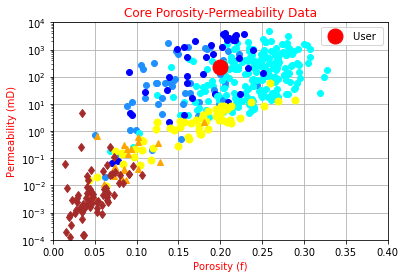


Input Poro-Perm Data: Porosity = 0.2 and Permeability = 222.0

Most Frequent Rock_Index with  KNN = 5 using normlalized Poro-Perm data.
     Rock_Index = 1.0 , which is a Macro-Porous Rock with Meso-Porous Grains


Estimated Thomeer Parameters from KNN = 5  using normlalized Poro-Perm data.
     G1 = 0.8263852320756602 ,  Pd1 = 3.338602152930984 , BV1(%) = 15.605476070103778
     G2 = 0.19297137788458502 ,  Pd2 = 209.57818815854688 , BV2(%) = 4.807285762361828



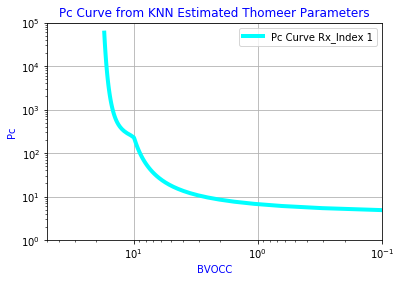


Capillary Pressure Curve for a Rock_Index = 1.0 sample, which is a Macro-Porous Rock with Meso-Porous Grains



In [3]:
from colorama import Fore, Style


# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #           
# # #              Plot to Figures
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================


# =============================================================================
# Porosity vs. Permeability Cross Plot with Rock Types on Z-axis
# =============================================================================
plt.figure(0)

for i in range(0,len(thomeer_core_data),1):
    if ROCK_INDEX[i]   == 1:
        plt.semilogy(Porosity[i], Permeability[i], color='cyan', linestyle='none', marker='o', markerfacecolor='cyan', markersize=6)
    elif ROCK_INDEX[i]  == 2: 
        plt.semilogy(Porosity[i], Permeability[i], color='dodgerblue', linestyle='none', marker='o', markerfacecolor='dodgerblue', markersize=6)  
    elif ROCK_INDEX[i]  == 3:
        plt.semilogy(Porosity[i], Permeability[i], color='blue', linestyle='none', marker='o', markerfacecolor='blue', markersize=6)
    elif ROCK_INDEX[i]  == 4:
        plt.semilogy(Porosity[i], Permeability[i], color='yellow', linestyle='none', marker='o', markerfacecolor='yellow', markersize=7)
    elif ROCK_INDEX[i]  == 5:
        plt.semilogy(Porosity[i], Permeability[i], color='orange', linestyle='none', marker='^', markerfacecolor='orange', markersize=6)
    else:
        plt.semilogy(Porosity[i], Permeability[i], color='brown', linestyle='none', marker='d', markerfacecolor='brown', markersize=6)


plt.semilogy(Por, Perm, 'ro', linewidth=0,  markersize=15 , label='User ')
plt.xlim(0,0.4)
plt.ylim(0.0001, 10000)
plt.title("Core Porosity-Permeability Data", color = 'red')
plt.ylabel('Permeability (mD)', color = 'red')
plt.xlabel('Porosity (f)', color = 'red' )
plt.grid(True)
plt.legend()
#plt.show(block=False)
plt.show()


print()
print(Fore.RED +'Input Poro-Perm Data: Porosity =',Por,'and Permeability =',Perm)
print()

print(Fore.RED +'Most Frequent Rock_Index with  KNN =',n_neighbors,'using normlalized Poro-Perm data.')    
print(Fore.RED + '     Rock_Index =', most_frequent(List), ', which is a', rocktype_remarks) 


print()
print()
print(Fore.GREEN +'Estimated Thomeer Parameters from KNN =',n_neighbors,' using normlalized Poro-Perm data.')
print(Fore.GREEN + '     G1 =',g1_est_knn, ',  Pd1 =',pd1_est_knn, ', BV1(%) =',bv1_est_knn) 
print(Fore.GREEN + '     G2 =',g2_est_knn, ',  Pd2 =',pd2_est_knn, ', BV2(%) =',bv2_est_knn) 
print(Style.RESET_ALL) 
#print('back to normal now') 




# =============================================================================
# Capillary Pressure Plot
# =============================================================================
plt.figure(1)
#plt.loglog(x, y  , 'g-', linewidth=1, label='Inv Dist Weighted Pc Curve')

if most_frequent(List)   == 1:
    plt.loglog(x, y, color='cyan', linestyle='solid', linewidth=4, label='Pc Curve Rx_Index 1')
elif most_frequent(List)   == 2: 
    plt.loglog(x, y, color='dodgerblue', linestyle='solid', linewidth=4, label='Pc Curve Rx_Index 2')
elif most_frequent(List)   == 3:
    plt.loglog(x, y, color='blue', linestyle='solid', linewidth=4, label='Pc Curve Rx_Index 3')
elif most_frequent(List)   == 4:
    plt.loglog(x, y, color='yellow', linestyle='solid' , linewidth=5, label='Pc Curve Rx_Index 4')
    plt.loglog(x, y, color='black' , linestyle='dotted', linewidth=2)
elif most_frequent(List)   == 5:
    plt.loglog(x, y, color='orange', linestyle='solid', linewidth=4, label='Pc Curve Rx_Index 5')
else:
    plt.loglog(x, y, color='brown', linestyle='solid', linewidth=4, label='Pc Curve Rx_Index 6')


#plt.loglog(x, y, 'r-' , linewidth=3, label='Pc Curve from KNN')

plt.xlim(50, 0.1)
#plt.gca().invert_xaxis()
plt.ylim(1, 100000)
plt.title("Pc Curve from KNN Estimated Thomeer Parameters", color = 'blue')
plt.ylabel('Pc', color = 'blue')
plt.xlabel('BVOCC', color = 'blue')
plt.grid(True)
plt.legend()
plt.show()

print()
#print(Fore.RED +'Estimated Clerke Arab D Carbonate Rock Type from KNN =',n_neighbors,' using normlalized Poro-Perm data')    
print(Fore.BLUE + 'Capillary Pressure Curve for a Rock_Index =', most_frequent(List), 'sample, which is a', rocktype_remarks) 

print(Style.RESET_ALL) 
